In [1]:
from itertools import combinations
from z3 import *
import sys
import os
import re
import math

sys.path.append(os.path.realpath('../../utils'))
from problem import ProblemInstance, parse_problem_file
from solution import SolutionInstance, Circuit
from initial_solution import construct_initial_solution

In [2]:
# Define complex constraints
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one(solver, bool_vars):
    solver.add(at_most_one(bool_vars))
    solver.add(at_least_one(bool_vars))

In [3]:
inst:ProblemInstance = parse_problem_file('../../instances/ins-2.txt')
print(inst.format_for_dzn())

w = 9;
n = 5;
measures = [|3, 9,
|3, 6,
|3, 5,
|3, 4,
|3, 3,
|];


With these functions we can index the circuits' width and height

In [9]:
W = inst.wg

def get_cw(circ:int, inst):
    return inst.circuits[circ].w

def get_ch(circ:int, inst):
    return inst.circuits[circ].h

Create initial solution

In [10]:
init_inst = construct_initial_solution(inst)
max_h = max([circ.y0 + circ.h for circ in init_inst.circuits])

1. Create all boolean variables for the circuits. We have:
- $px_{c,e}$ indicates that circuit $c$ is placed at a x-axis position less or equal than $e$ (i.e. $x_c \leq e$)
- $py_{c,f}$ indicates that circuit $c$ is placed at a y-axis position less or equal than $f$ (i.e. $y_c \leq f$)

In [11]:
px = [[Bool(f"px_{c}_{e}") for e in range(W)] for c in range(inst.n)]
py = [[Bool(f"py_{c}_{f}") for f in range(max_h)] for c in range(inst.n)]
lr = [[Bool(f"lr_{i}_{j}") for j in range(inst.n) if i != j] for i in range(inst.n)]
ud = [[Bool(f"ud_{i}_{j}") for j in range(inst.n) if i != j] for i in range(inst.n)]

This function is used to index lr and ud

In [12]:
def index_orders(var, c1, c2):
    if c1 == c2:
        raise ValueError
    if c2 > c1:
        return var[c1][c2-1]
    else:
        return var[c1][c2]

2. Create solver instance

In [13]:
s = Solver()

3. Constraints:

- The values for which it makes sense to have True boolean variables $px_{c, e}$ and $py_{c, f}$ depend for each circuit $c$:
    - $e \in \{0 \dots W-w_i\}$
    - $f \in \{0 \dots H-h_i\}$
- For circuit $i$ and for each available position $e$, we have that if $px_{i,e}$ is True, then also $px_{i,e+1}$ must be True, while if $px_{i,e}$ is False, $px_{i,e+1}$ can be anything (i.e. a circuit might start immediately after $e$ or later).
- The same is true on the y-axis.

So we have the following conditions:
$$
\lnot px_{i,e} \lor px_{i,e+1}
$$
$$
\lnot py_{i,f} \lor py_{i,f+1}
$$

In [15]:
for circ in range(inst.n):
    # The circuit should be placed somewhere
    s.add(at_least_one([px[circ][e] for e in range(W-get_cw(circ, inst)+1)]))
    s.add(at_least_one([py[circ][f] for f in range(max_h-get_ch(circ, inst)+1)]))
    # The above conditions ensuring order
    s.add([Or(Not(px[circ][e]), px[circ][e+1]) 
        for e in range(W-get_cw(circ, inst))])
    s.add([Or(Not(py[circ][f]), py[circ][f+1]) 
        for f in range(max_h-get_ch(circ, inst))])

- We can force a circuit to be at (0,0)

In [16]:
s.add(Or([
    And(px[circ][0], py[circ][0]) for circ in range(inst.n)
]))

- Non-overlapping constraints between each rectangle: for each pair of circuits $r_i$, $r_j$, ($i < j$) one must be before the other. 

- Also, the non-overlapping constraint can be decomposed into this formulation: for each pair of rectangles $r_i$ and $r_j$ ($1 \leq i < j \leq n$), we have:
$$
(x_i + w_i \leq x_j) \lor (x_j + w_j \leq x_i) \lor (y_i + h_i \leq y_j) \lor (y_j + h_j \leq y_i)
$$

- With our boolean logic variables we can say that:
    - On the x-axis, if one is before the other (eg. $c_i$ is before $c_j$, so $lr_{i,j} = T$), then for all integers $e$ such that $0 \leq e < W−w_i$, if $c_i$ is placed after $e$, then $c_j$ cannot be placed before $e+w_i$ (i.e. if $c_i$ was placed at $e+1$, it would occupy all cells up to $e+w_i$ and that would be the first available position for the next circuit). We can say something similar when $c_j$ is before $c_i$: then $c_i$ cannot be before position $e+w_j$ if $c_j$ is not before position $0 \leq e < W−w_j$. This can be encoded into the following pair of constraints:
    $$
    \lnot lr_{i,j} \lor px_{i,e} \lor \lnot px_{j,e+w_i}
    $$
    $$
    \lnot lr_{j,i} \lor px_{j,e} \lor \lnot px_{i,e+w_j}
    $$
    - On the y-axis a similar condition occurs.
    $$
    \lnot ud_{i,j} \lor py_{i,f} \lor \lnot py_{j, f+h_i}
    $$
    $$
    \lnot ud_{j,i} \lor py_{j,f} \lor \lnot py_{i, f+h_j}
    $$
- Furthermore, if $i$ is placed before $j$, $c_j$ cannot be placed in the first $w_i$ cells and if $j$ is placed before $i$ $c_i$ cannot be placed in the first $w_j$ cells. A similar constraint is available in the y-axis and can be formalized with the following constraints:
    - $\forall e \in \{0,\dots,w_i\}:  \lnot lr_{i,j} \lor \lnot px_{j,e}$
    - $\forall e \in \{0,\dots,w_j\}:  \lnot lr_{j,i} \lor \lnot px_{i,e}$
    - $\forall f \in \{0,\dots,h_i\}:  \lnot ud_{i,j} \lor \lnot py_{j,f}$
    - $\forall f \in \{0,\dots,h_j\}:  \lnot ud_{j,i} \lor \lnot py_{i,f}$

In [18]:
for ci, cj in combinations(range(inst.n), 2):
    # One must be before the other in some way
    s.add(Or(
        index_orders(lr, ci, cj),
        index_orders(lr, cj, ci),
        index_orders(ud, ci, cj),
        index_orders(ud, cj, ci)
    ))
    # The complex constraint specified above:
    #### HORIZONTAL ####
    # If i is before j, then px[cj] cannot be before ci_w
    for e in range(get_cw(ci, inst)):
        s.add(Or(
            Not(index_orders(lr, ci, cj)),
            Not(px[cj][e])
        ))
    # Then, we pose the full constraint
    for e in range(W-get_cw(ci, inst)):
        s.add(Or(
            Not(index_orders(lr, ci, cj)), 
            px[ci][e],
            Not(px[cj][e+get_cw(ci, inst)])
        ))
    # If j is before i, then px[ci] cannot be before cj_w
    for e in range(get_cw(cj, inst)):
        s.add(Or(
            Not(index_orders(lr, cj, ci)),
            Not(px[ci][e])
        ))
    # Then, we have the full constraint
    for e in range(W-get_cw(cj, inst)):
        s.add(Or(
            Not(index_orders(lr, cj, ci)), 
            px[cj][e],
            Not(px[ci][e+get_cw(cj, inst)])
        ))
    #### VERTICAL ####
    # If i is above j, then px[cj] cannot be before ci_w
    for f in range(get_ch(ci, inst)):
        s.add(Or(
            Not(index_orders(ud, ci, cj)),
            Not(py[cj][f])
        ))
    # Then, we have the full constraint
    for f in range(max_h-get_ch(ci, inst)):
        s.add(Or(
            Not(index_orders(ud, ci, cj)), 
            py[ci][f],
            Not(py[cj][f+get_ch(ci, inst)])
        ))
    # If j is above i, then py[ci] cannot be before cj_h
    for f in range(get_ch(cj, inst)):
        s.add(Or(
            Not(index_orders(ud, cj, ci)),
            Not(py[ci][f])
        ))
    # Then, we have the full constraint
    for f in range(max_h-get_ch(cj, inst)):
        s.add(Or(
            Not(index_orders(ud, cj, ci)), 
            py[cj][f],
            Not(py[ci][f+get_ch(cj, inst)])
        ))

In [19]:
if s.check() == sat:
    m = s.model()
    true_vars = [var for var in s.model() if is_true(m[var])]
    print(true_vars)
else:
    print("Failed to solve")

[py_3_4, py_1_1, py_0_11, py_4_10, py_3_5, lr_0_2, py_0_5, py_3_9, px_0_4, py_4_7, px_4_6, px_1_3, py_4_1, px_1_2, py_4_0, py_0_7, py_1_2, px_0_6, py_1_3, py_0_4, py_4_3, px_0_3, px_1_5, py_0_9, py_1_6, py_4_4, px_2_6, lr_1_3, py_0_3, px_0_5, py_4_2, ud_4_2, py_1_5, py_1_4, px_1_1, py_0_12, ud_1_2, py_4_5, px_1_6, py_0_8, py_2_8, ud_3_2, ud_4_3, px_3_6, py_1_0, py_4_9, py_4_8, lr_0_4, py_1_7, lr_1_4, py_3_6, py_3_7, lr_0_3, py_0_10, py_4_6, py_0_2, px_1_4, px_1_0, lr_1_0, py_3_8]


[3, 0, 6, 6, 6] [2, 0, 8, 4, 0]
Solution h: 13
Adding 3x9 circuit at (3, 2)
Adding 3x6 circuit at (0, 0)
Adding 3x5 circuit at (6, 8)
Adding 3x4 circuit at (6, 4)
Adding 3x3 circuit at (6, 0)


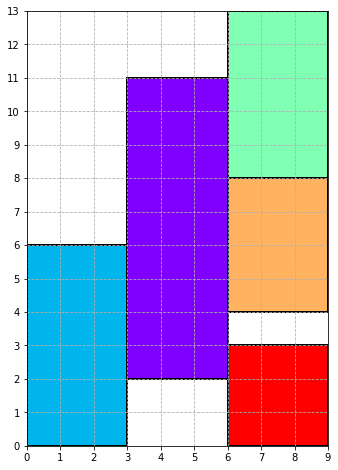

In [21]:
assignments_x = []
assignments_y = []
for circ in range(inst.n):
    assignments_x.append(min([int(str(var).split('_')[-1])
        for var in true_vars 
        if re.match(f'px_{circ}', str(var))]
    ))
    assignments_y.append(min([int(str(var).split('_')[-1])
        for var in true_vars 
        if re.match(f'py_{circ}', str(var))]
    ))
sol_h = max([assignments_y[i] + get_ch(i, inst) for i in range(inst.n)])
print(assignments_x, assignments_y)
print("Solution h: {}".format(sol_h))

solution = SolutionInstance(
    inst.wg, sol_h, inst.n,
    [ Circuit(get_cw(i, inst), get_ch(i, inst), assignments_x[i], assignments_y[i]) 
        for i in range(inst.n) ]
)
solution.draw()

We can have a lower bound to the optimal height of the board ($opt\_h$) dividing the total area of the circuits by $W$: $low\_h = \lfloor \frac{\sum_i h_i w_i}{W} \rfloor$.
If there are no empty spaces in the board this is equal to the optimal height, otherwise it's always true that $opt\_h \geq low\_h$

In [22]:
low_h = math.floor(sum([get_ch(circ, inst)*get_cw(circ, inst) for circ in range(inst.n)]) / W)
low_h

9

We can pack all of these constraints into a single function:

In [23]:
def twoOPP(inst:ProblemInstance):
    # Create new solver
    s = Solver()
    # Create initial solution, obtain higher bound for h
    init_inst = construct_initial_solution(inst)
    max_h = max([circ.y0 + circ.h for circ in init_inst.circuits])
    # Utility functions and constants
    W = inst.wg
    # Create variables for the problem
    px = [[Bool(f"px_{c}_{e}") for e in range(W)] for c in range(inst.n)]
    py = [[Bool(f"py_{c}_{f}") for f in range(max_h)] for c in range(inst.n)]
    lr = [[Bool(f"lr_{i}_{j}") for j in range(inst.n) if i != j] for i in range(inst.n)]
    ud = [[Bool(f"ud_{i}_{j}") for j in range(inst.n) if i != j] for i in range(inst.n)]
    # Constraints:
    # A)
    for circ in range(inst.n):
        # The circuit should be placed somewhere
        s.add(at_least_one([px[circ][e] for e in range(W-get_cw(circ, inst)+1)]))
        s.add(at_least_one([py[circ][f] for f in range(max_h-get_ch(circ, inst)+1)]))
        # The above conditions ensuring order
        s.add([Or(Not(px[circ][e]), px[circ][e+1]) 
            for e in range(W-get_cw(circ, inst))])
        s.add([Or(Not(py[circ][f]), py[circ][f+1]) 
            for f in range(max_h-get_ch(circ, inst))])

    # B)
    s.add(Or([
        And(px[circ][0], py[circ][0]) for circ in range(inst.n)
    ]))

    # C)
    for ci, cj in combinations(range(inst.n), 2):
        # One must be before the other in some way
        s.add(Or(
            index_orders(lr, ci, cj),
            index_orders(lr, cj, ci),
            index_orders(ud, ci, cj),
            index_orders(ud, cj, ci)
        ))
        # The complex constraint specified above:
        #### HORIZONTAL ####
        # If i is before j, then px[cj] cannot be before ci_w
        for e in range(get_cw(ci, inst)):
            s.add(Or(
                Not(index_orders(lr, ci, cj)),
                Not(px[cj][e])
            ))
        # Then, we pose the full constraint
        for e in range(W-get_cw(ci, inst)):
            s.add(Or(
                Not(index_orders(lr, ci, cj)), 
                px[ci][e],
                Not(px[cj][e+get_cw(ci, inst)])
            ))
        # If j is before i, then px[ci] cannot be before cj_w
        for e in range(get_cw(cj, inst)):
            s.add(Or(
                Not(index_orders(lr, cj, ci)),
                Not(px[ci][e])
            ))
        # Then, we have the full constraint
        for e in range(W-get_cw(cj, inst)):
            s.add(Or(
                Not(index_orders(lr, cj, ci)), 
                px[cj][e],
                Not(px[ci][e+get_cw(cj, inst)])
            ))
        #### VERTICAL ####
        # If i is above j, then px[cj] cannot be before ci_w
        for f in range(get_ch(ci, inst)):
            s.add(Or(
                Not(index_orders(ud, ci, cj)),
                Not(py[cj][f])
            ))
        # Then, we have the full constraint
        for f in range(max_h-get_ch(ci, inst)):
            s.add(Or(
                Not(index_orders(ud, ci, cj)), 
                py[ci][f],
                Not(py[cj][f+get_ch(ci, inst)])
            ))
        # If j is above i, then py[ci] cannot be before cj_h
        for f in range(get_ch(cj, inst)):
            s.add(Or(
                Not(index_orders(ud, cj, ci)),
                Not(py[ci][f])
            ))
        # Then, we have the full constraint
        for f in range(max_h-get_ch(cj, inst)):
            s.add(Or(
                Not(index_orders(ud, cj, ci)), 
                py[cj][f],
                Not(py[ci][f+get_ch(cj, inst)])
            ))

    return s

In [25]:
def solve_problem_and_show(s:Solver, inst:ProblemInstance):
    if s.check() == sat:
        m = s.model()
        true_vars = [var for var in s.model() if is_true(m[var])]
        assignments_x = []
        assignments_y = []
        for circ in range(inst.n):
            assignments_x.append(min([int(str(var).split('_')[-1])
                for var in true_vars 
                if re.match(f'px_{circ}', str(var))]
            ))
            assignments_y.append(min([int(str(var).split('_')[-1])
                for var in true_vars 
                if re.match(f'py_{circ}', str(var))]
            ))
        sol_h = max([assignments_y[i] + get_ch(i, inst) for i in range(inst.n)])
        print(assignments_x, assignments_y)
        print("Solution h: {}".format(sol_h))

        solution = SolutionInstance(
            inst.wg, sol_h, inst.n,
            [ Circuit(get_cw(i, inst), get_ch(i, inst), 
                assignments_x[i], assignments_y[i]) 
                for i in range(inst.n) ]
        )
        solution.draw()
    else:
        print("Failed to solve")

[9, 6, 0, 3, 0, 0, 6, 9] [1, 0, 0, 3, 9, 12, 13, 11]
Solution h: 17
Adding 3x9 circuit at (9, 1)
Adding 3x8 circuit at (6, 0)
Adding 3x7 circuit at (0, 0)
Adding 3x6 circuit at (3, 3)
Adding 6x3 circuit at (0, 9)
Adding 3x5 circuit at (0, 12)
Adding 3x4 circuit at (6, 13)
Adding 3x3 circuit at (9, 11)


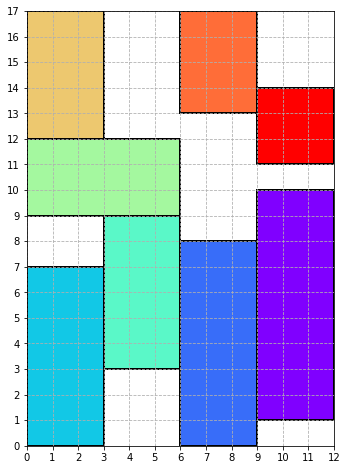

In [29]:
instance = parse_problem_file('../../instances/ins-5.txt')
solve_problem_and_show(twoOPP(instance), instance)